In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit import IBMQ, Aer
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import random
from qiskit import IBMQ, assemble, transpile

import networkx as nx

#importing libraries 

In [2]:
from qiskit.providers.fake_provider import FakeNairobi
from qiskit.providers import ibmq

In [3]:
# E: array of tuple of nodes connected with edges
# N: Number of nodes in the graph
# Function to draw graph
# Draws the graph for a given sequence of edges

def graph_draw(E):
    
    G = nx.Graph(E)
    nx.draw_circular(G, node_size = 1000, node_color = 'orange', width = [4 for iz in range(len(E))],
                    with_labels = True, font_color = 'white')
    

In [4]:
# E: Sequence of tuples of nodes connected with edges
# N: Number of nodes in the graph
# Function for finding the connecting nodes
# Returns a dictionary containing neighbor nodes for each node

def connection_list(E, N):
    
    connection_list = {}
    
    for node in range(N):
        
        conn_list = []
        
        for edge in E:
            if edge[0]==node:
                conn_list.append(edge[1])
            if edge[1]==node:
                conn_list.append(edge[0])
                
        connection_list.update({node:conn_list})
        
    conn_lis = [[key]+connection_list[key] for key in connection_list.keys()]
        
        
    return conn_lis

## Quantum Part

In [5]:
# n: number of qubits in the circuit
# function for Dk clause

def D_k_clause(circ, n, gamma1):
    
    for iz in range(n):
        circ.x(iz)
        circ.crz(gamma1[iz], iz, n)
        circ.x(iz)
        circ.barrier()
        
    return circ

In [6]:
# lis: list containing qubits to be controlled for OR gate
# n: number of qubits in the circuit without ancilla qubits
# m: number of ancilla qubits
# function for multi-controlled OR+Rz gate

def mcORz(circ, lis, n, gamma):
    
    k = len(lis)
    
    
    for iz in range(k):
        circ.x(lis[iz])
        
    circ.mcx(lis, n)
    circ.rz(gamma, n)
    circ.mcx(lis, n)
    
    for iz in range(k):
        circ.x(lis[iz])
        
    
    return circ

In [7]:
# n: number of qubits in the main circuit
# conn_list: array of list containing connected nodes

def T_k_clause(circ, conn_list, n, gamma2):
    
    iz=0
    for lis in conn_list:
        
        mcORz(circ, lis, n, gamma2[iz])
        circ.barrier()
        iz += 1
        
    return circ

The D and the T clause together form the seperator matrix

In [8]:
# Mixer circuit


def mixer(circ, n, beta):
    
    for iz in range(n):
    
        circ.rx(2*beta, iz)
    
    return circ


In [9]:
# classical function for T_k clause

def T(bitstring):
    
    T = [0]*n
    
    z_k = list(reversed([int(x) for x in bitstring]))
    
    for k in range(n):
        conn_list = conn_lis[k]

        for iz in conn_list:
            if z_k[k]==1 or z_k[iz]==1:
                T[k] = 1
                
    return sum(T)

In [10]:
# classical function for D_k clause

def D(bitstring):
    
    D = [0]*n
    
    z_k = list(reversed([int(x) for x in bitstring]))
    
    for k in range(n):
        
        if z_k[k]==0:
            D[k] = 1
                
    return sum(D)

In [11]:
# Cost function

def cost_fun(parameters):
    
    gamma1 = parameters[0:n*num_iter]
    gamma2 = parameters[n*num_iter : 2*n*num_iter]
    beta = parameters[2*n*num_iter]
    
    dsp_circuit = QuantumCircuit(n+1, n)
    
    dsp_circuit.h(range(n))
    dsp_circuit.x(n)
    
        
    for iz in range(num_iter):
        
        D_k_clause(dsp_circuit, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circuit, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circuit, n, beta)
        
    dsp_circuit.measure(range(n), range(n))


    backend = Aer.get_backend('qasm_simulator')
    qc_res = transpile(dsp_circuit, backend=backend, optimization_level=3)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    
    shots = shots_
    
    cost = 0
    
    for key in counts.keys():
        cost -= counts[key]*(T(key) + D(key))/shots
        
    print(cost)
    return cost
    

In [12]:
# Minimize the cost function

def dsp_qaoa(num_itr, n):
    
    out = minimize(cost_fun, x0=[float(random.randint(0,3000))/1000 for i in range(2*n*num_itr+1)], 
                   method = "COBYLA")
    return out

In [13]:
# Plots histogram for given parameters

def plot_result (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta)


    dsp_circ.measure(range(n), range(n))

    job = execute(dsp_circ, backend=Aer.get_backend('aer_simulator'), shots=1024)
    results = job.result()
    counts = results.get_counts()
    
    return  plot_histogram(counts)

In [14]:
"""Input 
    - N: Number of nodes in the graph
    - E: Sequence of tuples of nodes connected using edges
    - num_iter = number of iterations for D_k and T_k quantum circuits""" 

N = 3
E = [(0,1), (1,2)]
num_iter = 5

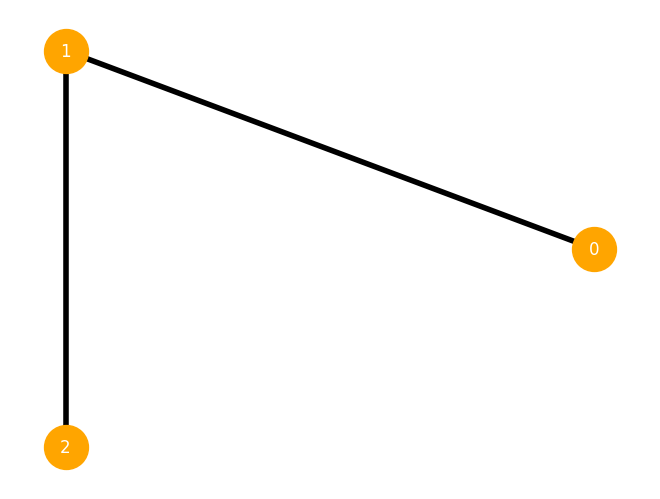

In [15]:
# Defining parameters to be run after giving the input

n = N
conn_lis = connection_list(E, N)
shots_ = 1024
graph_draw(E)

In [16]:
out = dsp_qaoa(num_iter, n)
out

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-3.8203125
-3.943359375
-4.033203125
-4.0751953125
-4.0400390625
-4.154296875
-4.09375
-4.0986328125
-4.0546875
-4.17578125
-4.1279296875
-4.193359375
-4.169921875
-4.1513671875
-4.111328125
-4.240234375
-3.984375
-4.099609375
-4.09375
-4.1611328125
-4.14453125
-4.15625
-4.1123046875
-4.2705078125
-4.3095703125
-4.265625
-4.251953125
-4.3701171875
-4.0625
-4.212890625
-4.373046875
-3.73046875
-3.572265625
-4.419921875
-3.81640625
-4.4580078125
-4.4599609375
-4.4443359375
-4.41015625
-4.451171875
-4.306640625
-4.435546875
-4.2470703125
-4.4375
-4.29296875
-4.4775390625
-4.4140625
-4.447265625
-4.353515625
-4.5419921875
-4.1962890625
-4.5322265625
-4.2197265625
-4.4931640625
-4.353515625
-4.5263671875
-4.515625
-4.5478515625
-4.4482421875
-4.546875
-4.09765625
-4.4609375
-4.421875
-4.552734375
-3.7099609375
-4.5693359375
-3.767578125
-4.5234375
-3.806640625
-4.51171875
-4.560546875
-4.5234375
-4.55078125
-4.5234375
-4.5458984375
-4.515625
-4.5693359375
-4.513671875
-4.5830078125
-4.5
-4.

     fun: -4.7412109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 378
  status: 1
 success: True
       x: array([3.82446749, 1.08307115, 2.56766363, 0.33837718, 3.2156094 ,
       2.14551561, 0.55912279, 1.93253112, 3.81501634, 2.37322755,
       3.93884102, 1.32915946, 2.32746021, 2.65722119, 1.45273119,
       1.47602915, 2.96058923, 1.13443295, 0.59503889, 2.30702218,
       0.26188589, 2.40061162, 3.17602742, 4.44429476, 2.51557224,
       1.05468121, 1.64245209, 0.88178341, 0.51613961, 3.62277482,
       2.37015306])

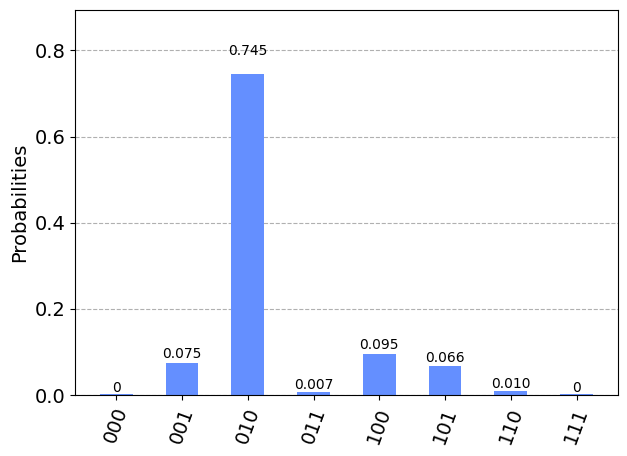

In [17]:
x1 = [3.82446749, 1.08307115, 2.56766363, 0.33837718, 3.2156094 ,
       2.14551561, 0.55912279, 1.93253112, 3.81501634, 2.37322755,
       3.93884102, 1.32915946, 2.32746021, 2.65722119, 1.45273119,
       1.47602915, 2.96058923, 1.13443295, 0.59503889, 2.30702218,
       0.26188589, 2.40061162, 3.17602742, 4.44429476, 2.51557224,
       1.05468121, 1.64245209, 0.88178341, 0.51613961, 3.62277482,
       2.37015306]
plot_result(x1)

In [18]:
# nodes = 3, num_iter = 3

N = 3
E = [(0,1), (1,2)]
num_iter = 1 

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

out = dsp_qaoa(num_iter, n)
out

-3.931640625
-3.9765625
-3.8759765625
-4.0087890625
-4.2001953125
-4.3896484375
-4.42578125
-3.7900390625
-3.7041015625
-4.474609375
-3.6943359375
-4.3544921875
-3.7060546875
-4.505859375
-4.501953125
-4.4833984375
-4.505859375
-4.13671875
-3.8740234375
-4.4833984375
-4.5
-4.357421875
-4.509765625
-4.556640625
-4.49609375
-4.55859375
-4.5029296875
-4.5576171875
-4.5556640625
-4.5625
-4.533203125
-4.5615234375
-4.5380859375
-4.55859375
-4.5537109375
-4.5595703125
-4.5576171875
-4.55859375
-4.564453125
-4.5595703125
-4.5634765625
-4.5576171875
-4.564453125
-4.5634765625
-4.5595703125
-4.564453125
-4.560546875
-4.5634765625
-4.55859375
-4.564453125
-4.564453125
-4.564453125
-4.560546875
-4.564453125
-4.5654296875
-4.5634765625
-4.5654296875
-4.564453125
-4.5654296875
-4.564453125
-4.5634765625
-4.5654296875
-4.5654296875
-4.5654296875
-4.5634765625
-4.5654296875
-4.564453125
-4.5634765625
-4.564453125
-4.5654296875
-4.564453125
-4.5654296875
-4.564453125
-4.5654296875
-4.564453125
-4.5644

     fun: -4.5654296875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 86
  status: 1
 success: True
       x: array([1.71501814, 2.76855668, 3.68734168, 2.32905736, 2.74900011,
       3.91696006, 2.5607422 ])

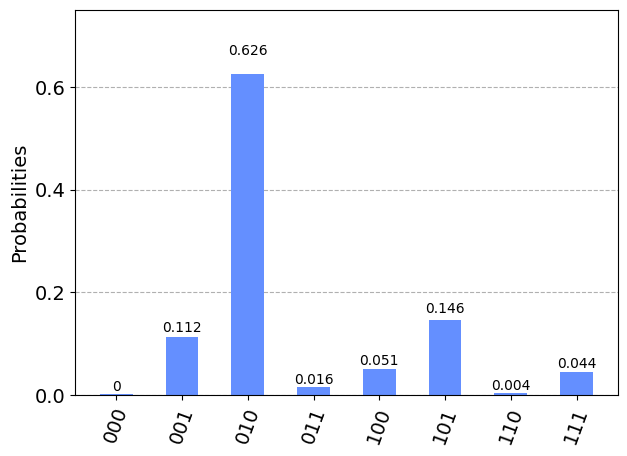

In [19]:
x = [1.71501814, 2.76855668, 3.68734168, 2.32905736, 2.74900011,
       3.91696006, 2.5607422 ]
plot_result(x)

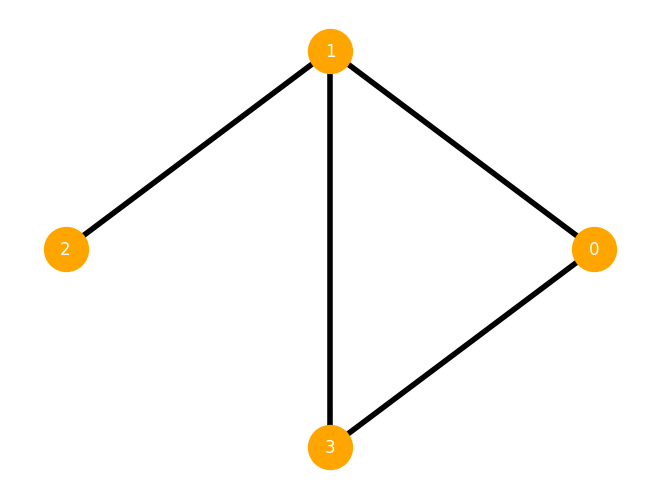

In [20]:
# For a 4 node graph

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [21]:
dsp_qaoa(num_iter, n)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-5.25
-5.3095703125
-5.21875
-5.2490234375
-5.3173828125
-5.333984375
-5.330078125
-5.3779296875
-5.431640625
-5.3603515625
-5.4853515625
-5.5009765625
-5.5361328125
-5.490234375
-5.556640625
-5.521484375
-5.4775390625
-5.65625
-5.5830078125
-5.7294921875
-5.7509765625
-5.6611328125
-5.7265625
-5.80859375
-5.650390625
-5.7958984375
-5.7041015625
-5.6748046875
-5.7958984375
-5.6474609375
-5.708984375
-5.71484375
-5.6474609375
-5.6748046875
-5.708984375
-5.677734375
-5.6748046875
-5.9365234375
-5.9130859375
-5.89453125
-5.798828125
-5.5576171875
-5.7236328125
-5.931640625
-5.47265625
-5.9482421875
-5.8046875
-5.970703125
-5.990234375
-6.0361328125
-5.9501953125
-6.0478515625
-5.8994140625
-6.0419921875
-5.8388671875
-6.015625
-5.7802734375
-6.015625
-5.7509765625
-6.0439453125
-5.7734375
-6.05078125
-5.8427734375
-6.0595703125
-5.990234375
-6.0595703125
-5.8515625
-6.0146484375
-5.9013671875
-5.953125
-5.890625
-6.056640625
-6.0107421875
-5.99609375
-5.7900390625
-6.03515625
-5.943359375

     fun: -6.396484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 478
  status: 1
 success: True
       x: array([4.78908336, 1.81360851, 0.87836663, 2.90041272, 2.19401183,
       0.54359482, 1.85897702, 2.11603529, 2.46367567, 1.38857875,
       1.86753264, 3.25908032, 0.31643468, 2.34141945, 0.59526885,
       2.69468218, 1.5115758 , 1.46707467, 1.30155779, 3.24291968,
       0.04541364, 0.45841957, 2.95885291, 0.27746749, 1.42860332,
       1.20254406, 2.14493036, 2.41995508, 1.10427812, 1.10100054,
       2.58185378, 1.66513707, 1.61706684, 1.82572597, 2.52460999,
       2.04896814, 1.63194543, 1.58205681, 0.21690863, 1.36063931,
       2.36415039])

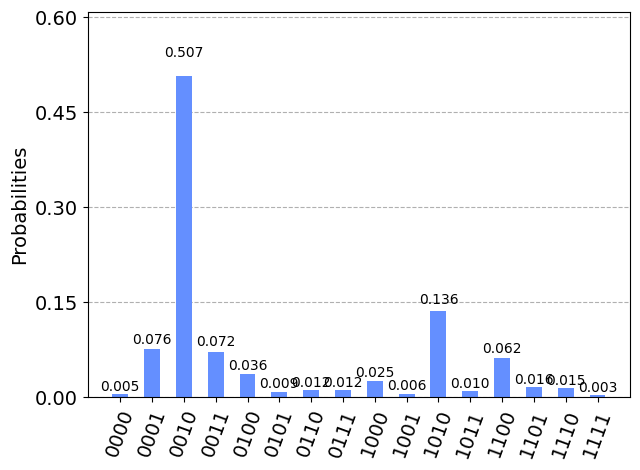

In [22]:
x2 = [4.78908336, 1.81360851, 0.87836663, 2.90041272, 2.19401183,
       0.54359482, 1.85897702, 2.11603529, 2.46367567, 1.38857875,
       1.86753264, 3.25908032, 0.31643468, 2.34141945, 0.59526885,
       2.69468218, 1.5115758 , 1.46707467, 1.30155779, 3.24291968,
       0.04541364, 0.45841957, 2.95885291, 0.27746749, 1.42860332,
       1.20254406, 2.14493036, 2.41995508, 1.10427812, 1.10100054,
       2.58185378, 1.66513707, 1.61706684, 1.82572597, 2.52460999,
       2.04896814, 1.63194543, 1.58205681, 0.21690863, 1.36063931,
       2.36415039]

plot_result(x2)

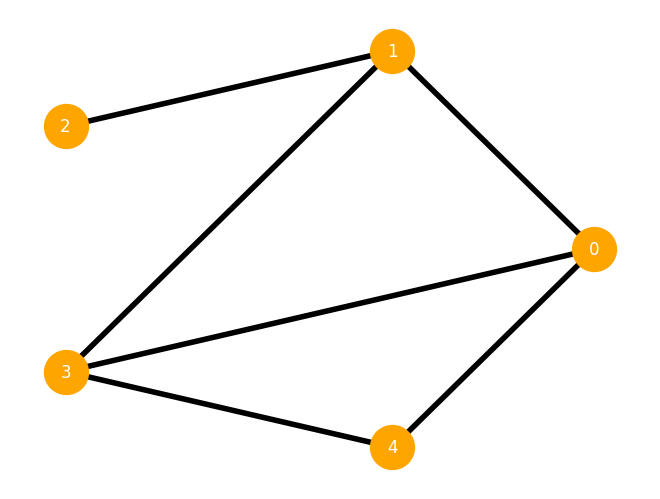

In [52]:
# For a 5 node graph

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [53]:
dsp_qaoa(num_iter, n)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


-7.08984375
-7.1181640625
-7.169921875
-7.0400390625
-7.2041015625
-7.2587890625
-7.275390625
-7.3095703125
-7.234375
-7.2998046875
-7.2626953125
-7.3515625
-7.28125
-7.306640625
-7.2822265625
-7.3984375
-7.4765625
-7.380859375
-7.4248046875
-7.3876953125
-7.5
-7.5400390625
-7.4619140625
-7.517578125
-7.4521484375
-7.5654296875
-7.490234375
-7.501953125
-7.3974609375
-7.490234375
-7.4970703125
-7.5576171875
-7.5048828125
-7.5478515625
-7.5576171875
-7.49609375
-7.5185546875
-7.5693359375
-7.541015625
-7.4521484375
-7.4833984375
-7.482421875
-7.5302734375
-7.5751953125
-7.5
-7.4951171875
-7.4990234375
-7.5322265625
-7.5595703125
-7.4990234375
-7.5322265625
-6.76171875
-6.8466796875
-7.5546875
-6.8330078125
-7.568359375
-6.83984375
-7.607421875
-6.826171875
-7.5654296875
-6.65234375
-7.60546875
-7.52734375
-7.5927734375
-7.576171875
-7.615234375
-7.5966796875
-7.60546875
-7.607421875
-7.5908203125
-7.5400390625
-7.6171875
-7.5234375
-7.6025390625
-7.609375
-7.6181640625
-7.5654296875
-7.

     fun: -7.728515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 577
  status: 1
 success: True
       x: array([ 3.48920162,  3.87457944,  0.38559099,  2.78494814,  2.43236845,
        1.76493812,  3.5702512 ,  0.69254375,  2.33496194,  1.72902574,
        3.22963866,  0.48604316,  0.23560548,  1.20156177,  1.51636399,
        1.8777896 ,  0.08490928,  3.05291936,  1.02552919,  2.46133601,
        2.55290944,  2.28747164,  0.6307573 , -0.01743009,  3.34761355,
        1.3830963 ,  2.44197765,  2.76977887,  0.10320813,  0.71773783,
        2.52270832,  1.47850065,  0.08775633,  0.96014569,  3.32408399,
        3.1411785 ,  1.84548709,  2.98041046,  1.40084218,  0.61738692,
        2.84632081,  1.13758987,  3.00055704,  0.16162212,  2.90782903,
        2.73921684,  0.11950079,  1.11727466,  1.37328135,  0.32664359,
        2.63301759])

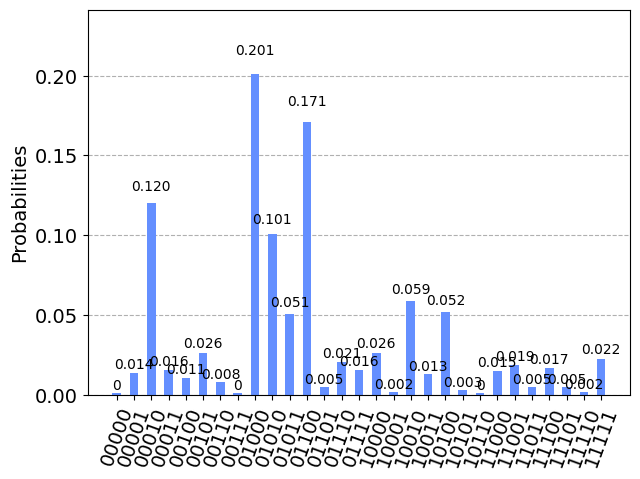

In [54]:
x3 = [ 3.48920162,  3.87457944,  0.38559099,  2.78494814,  2.43236845,
        1.76493812,  3.5702512 ,  0.69254375,  2.33496194,  1.72902574,
        3.22963866,  0.48604316,  0.23560548,  1.20156177,  1.51636399,
        1.8777896 ,  0.08490928,  3.05291936,  1.02552919,  2.46133601,
        2.55290944,  2.28747164,  0.6307573 , -0.01743009,  3.34761355,
        1.3830963 ,  2.44197765,  2.76977887,  0.10320813,  0.71773783,
        2.52270832,  1.47850065,  0.08775633,  0.96014569,  3.32408399,
        3.1411785 ,  1.84548709,  2.98041046,  1.40084218,  0.61738692,
        2.84632081,  1.13758987,  3.00055704,  0.16162212,  2.90782903,
        2.73921684,  0.11950079,  1.11727466,  1.37328135,  0.32664359,
        2.63301759]

plot_result(x3)

## Running on Noisy simulator

In [26]:
# Cost function_noisy

def cost_fun_noise(parameters):
    
    gamma1 = parameters[0:n*num_iter]
    gamma2 = parameters[n*num_iter : 2*n*num_iter]
    beta = parameters[2*n*num_iter]
    
    dsp_circuit = QuantumCircuit(n+1, n)
    
    dsp_circuit.h(range(n))
    dsp_circuit.x(n)
    
        
    for iz in range(num_iter):
        
        D_k_clause(dsp_circuit, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circuit, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circuit, n, beta)
        
    dsp_circuit.measure(range(n), range(n))


    backend = FakeNairobi()
    qc_res = transpile(dsp_circuit, backend=backend, optimization_level=3)
    counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
    
    shots = shots_
    
    cost = 0
    
    for key in counts.keys():
        cost -= counts[key]*(T(key) + D(key))/shots
        
    print(cost)
    return cost

In [27]:
def dsp_qaoa_noise(num_iter, n):
    
    out = minimize(cost_fun_noise, x0=[float(random.randint(0,3000))/1000 for i in range(2*n*num_iter+1)], 
                   method = "COBYLA")
    return out

In [28]:
# Plots histogram for given parameters on noisy simulation

def plot_result_noise (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta)


    dsp_circ.measure(range(n), range(n))

    job = execute(dsp_circ, backend=FakeNairobi(), shots=1024)
    results = job.result()
    counts = results.get_counts()
    
    return  plot_histogram(counts)

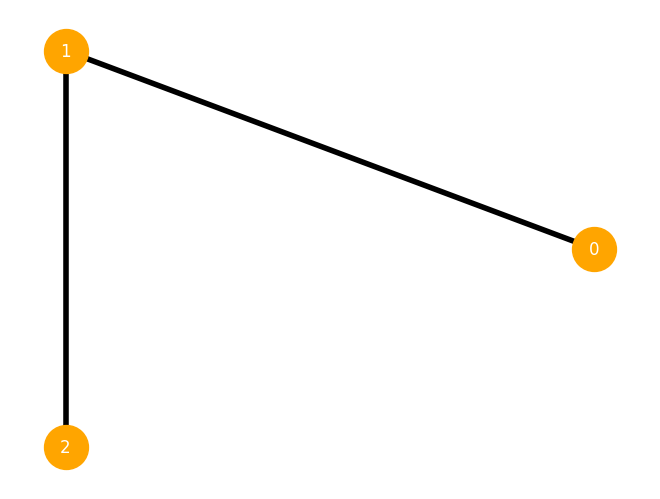

In [29]:
# Running the algorithm for 3 nodes on complete noisy simulator
# Nodes = 3
# Num_iter = 2

N = 3
E = [(0,1), (1,2)]
num_iter = 2

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

In [30]:
dsp_qaoa_noise(num_iter, n)

-3.8505859375
-3.8466796875
-3.85546875
-3.8564453125
-3.8544921875
-3.8369140625
-3.8564453125
-3.8447265625
-3.8525390625
-3.83984375
-3.859375
-3.8603515625
-3.859375
-3.9013671875
-3.86328125
-3.88671875
-3.8740234375
-3.92578125
-3.810546875
-3.8984375
-3.8994140625
-3.912109375
-3.9892578125
-3.9091796875
-3.9267578125
-3.9013671875
-3.93359375
-3.8828125
-3.9013671875
-3.98046875
-3.833984375
-3.9013671875
-3.91796875
-3.904296875
-3.9072265625
-3.9208984375
-3.99609375
-3.9052734375
-3.888671875
-3.9091796875
-3.904296875
-3.9951171875
-3.89453125
-3.912109375
-3.90234375
-3.904296875
-3.8974609375
-3.9892578125
-3.9189453125
-3.9130859375
-3.8857421875
-3.984375
-3.912109375
-3.888671875
-3.90625
-3.99609375
-3.91796875
-3.904296875
-3.9013671875
-3.908203125
-3.9873046875
-3.9091796875
-3.9013671875
-3.9091796875
-3.8896484375
-3.90625
-3.9853515625
-3.982421875
-3.984375
-3.904296875
-3.90625
-3.90234375
-3.9072265625
-3.8857421875
-3.888671875
-3.912109375
-3.9091796875
-3.

     fun: -3.9111328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 115
  status: 1
 success: True
       x: array([0.26508346, 0.71427527, 3.69314697, 0.45057375, 2.22082516,
       1.41969409, 1.75414968, 2.58827061, 2.11594177, 1.49934961,
       3.66672496, 2.91566941, 2.87996651])

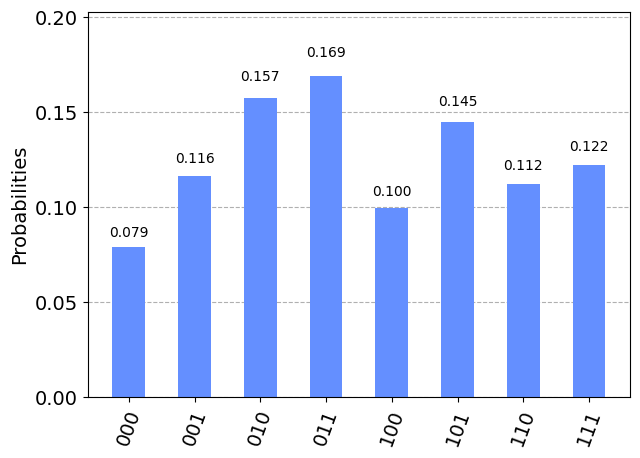

In [31]:
x = [0.26508346, 0.71427527, 3.69314697, 0.45057375, 2.22082516,
       1.41969409, 1.75414968, 2.58827061, 2.11594177, 1.49934961,
       3.66672496, 2.91566941, 2.87996651]

plot_result_noise(x)

In [32]:
# Nodes = 3
# Num_iter = 3

N = 3
E = [(0,1), (1,2)]
num_iter = 3

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

dsp_qaoa_noise(num_iter, n)

-3.791015625
-3.7978515625
-3.7802734375
-3.794921875
-3.7861328125
-3.767578125
-3.7890625
-3.78515625
-3.7666015625
-3.8056640625
-3.771484375
-3.7978515625
-3.796875
-3.802734375
-3.798828125
-3.7861328125
-3.7880859375
-3.78515625
-3.7822265625
-3.85546875
-3.853515625
-3.8486328125
-3.8916015625
-3.8486328125
-3.8720703125
-3.8662109375
-3.869140625
-3.8671875
-3.8720703125
-3.8525390625
-3.8720703125
-3.8662109375
-3.849609375
-3.8701171875
-3.869140625
-3.8681640625
-3.873046875
-3.857421875
-3.8525390625
-3.8623046875
-3.8681640625
-3.8623046875
-3.875
-3.8642578125
-3.8544921875
-3.865234375
-3.8671875
-3.8671875
-3.853515625
-3.8681640625
-3.8720703125
-3.8720703125
-3.853515625
-3.853515625
-3.8701171875
-3.8701171875
-3.8720703125
-3.8720703125
-3.853515625
-3.873046875
-3.853515625
-3.8525390625
-3.853515625
-3.8525390625
-3.853515625
-3.8701171875
-3.8720703125
-3.869140625
-3.8515625
-3.8701171875
-3.8515625
-3.8876953125
-3.87109375
-3.87109375
-3.853515625
-3.870117187

     fun: -3.8515625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 149
  status: 1
 success: True
       x: array([1.31894508, 1.65360292, 2.22099513, 1.25297861, 2.66796776,
       0.7279721 , 2.76197485, 2.2479991 , 1.83499169, 1.10000153,
       2.32802239, 0.34398008, 0.17698713, 2.8019962 , 1.0529746 ,
       0.26798612, 2.58901163, 0.06000134, 1.1260415 ])

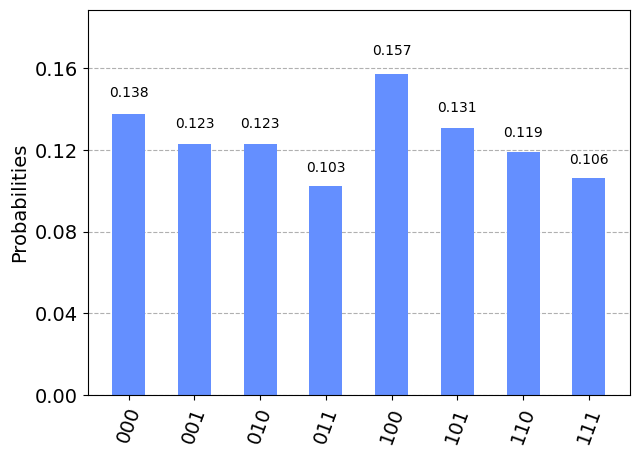

In [33]:
x = [1.31894508, 1.65360292, 2.22099513, 1.25297861, 2.66796776,
       0.7279721 , 2.76197485, 2.2479991 , 1.83499169, 1.10000153,
       2.32802239, 0.34398008, 0.17698713, 2.8019962 , 1.0529746 ,
       0.26798612, 2.58901163, 0.06000134, 1.1260415 ]

plot_result_noise(x)

In [34]:
# nodes = 3
# num_iter = 1

N = 3
E = [(0,1), (1,2)]
num_iter = 1

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

dsp_qaoa_noise(num_iter, n)

-3.8916015625
-3.94921875
-3.8857421875
-3.9091796875
-3.888671875
-3.921875
-3.8740234375
-3.8994140625
-3.94140625
-3.9306640625
-3.9013671875
-3.884765625
-3.9365234375
-3.884765625
-3.9013671875
-3.9248046875
-3.8515625
-3.884765625
-3.890625
-3.8916015625
-3.9169921875
-3.9052734375
-3.892578125
-3.912109375
-3.88671875
-3.9052734375
-3.8896484375
-3.892578125
-3.9384765625
-3.892578125
-3.892578125
-3.9208984375
-3.9013671875
-3.888671875
-3.8857421875
-3.8876953125
-3.904296875
-3.8896484375
-3.884765625
-3.8896484375
-3.884765625
-3.8984375
-3.9208984375
-3.892578125
-3.884765625
-3.8896484375
-3.919921875
-3.919921875
-3.919921875
-3.8916015625
-3.9208984375
-3.9208984375
-3.90625
-3.8896484375
-3.888671875
-3.892578125
-3.88671875
-3.88671875
-3.919921875
-3.921875
-3.919921875
-3.88671875


     fun: -3.88671875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 62
  status: 1
 success: True
       x: array([1.34698312, 2.82802678, 0.26705671, 0.26005018, 1.63100516,
       1.52504199, 1.4730384 ])

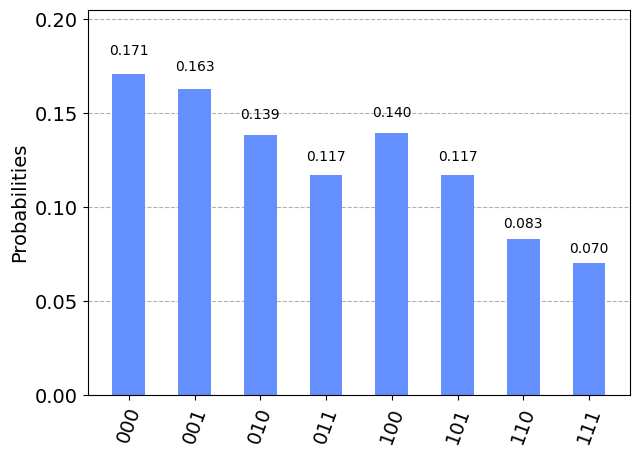

In [35]:
x = [1.34698312, 2.82802678, 0.26705671, 0.26005018, 1.63100516,
       1.52504199, 1.4730384 ]


plot_result_noise(x)

In [36]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 3
# num_iter = 5

N = 3
E = [(0,1), (1,2)]
num_iter = 5

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

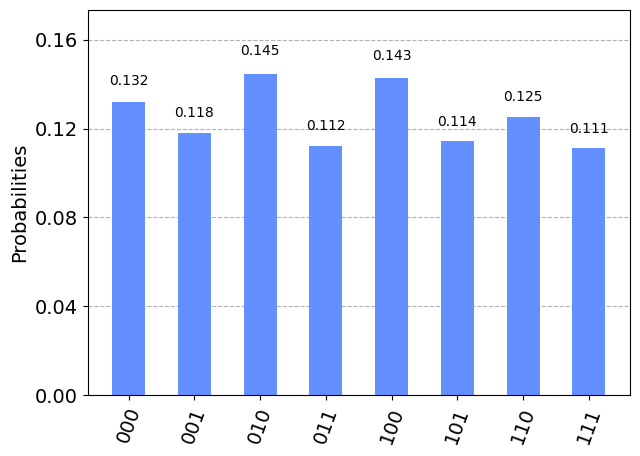

In [37]:

plot_result_noise(x1)


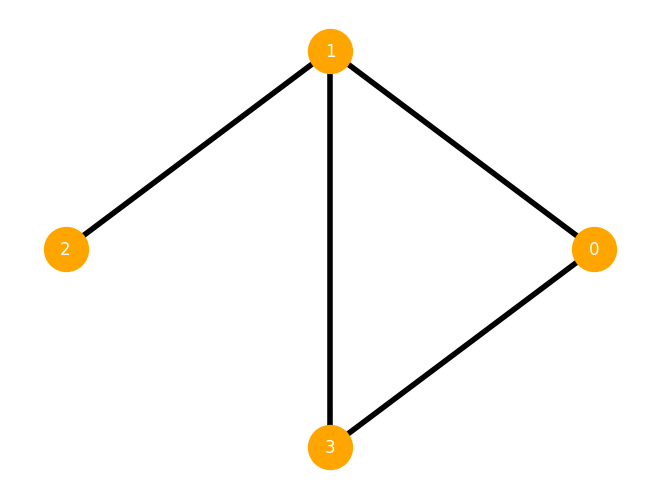

In [38]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 4
# num_iter = 5

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

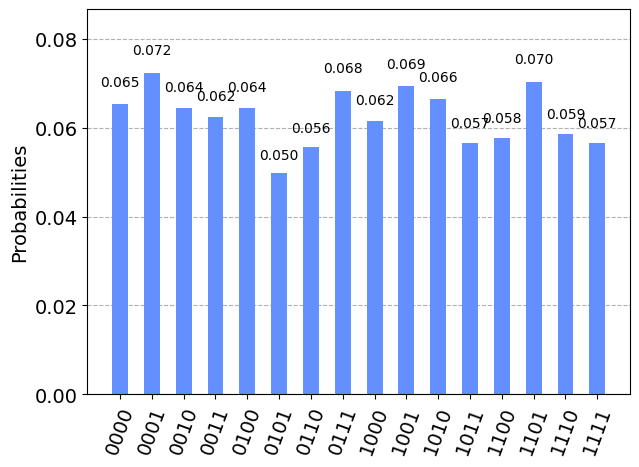

In [39]:
plot_result_noise(x2)

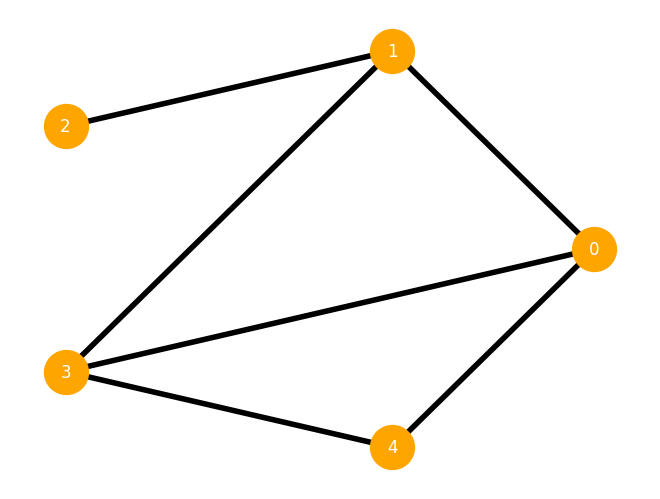

In [40]:
""" Running the cost function on non-noisy simulator and final circuit on noisy simulator"""

# nodes = 5
# num_iter = 5

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

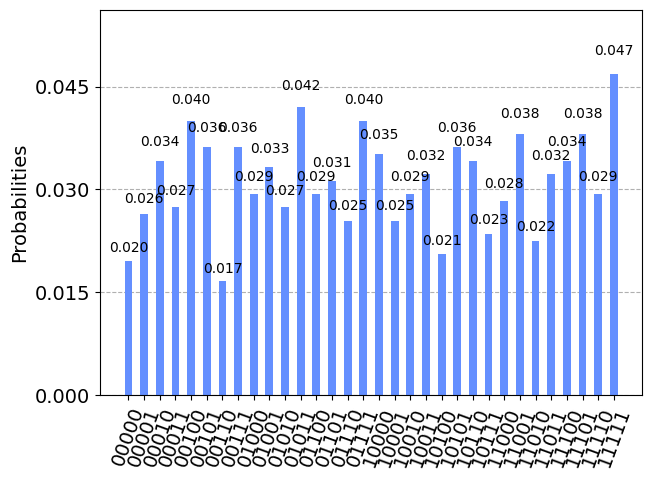

In [41]:
plot_result_noise(x3)

## Running on IBM Quantum computer

In [42]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [43]:
from qiskit.tools.monitor import job_monitor

In [44]:
backend_ibm = provider.get_backend('ibm_oslo')
backend_ibm

<IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [45]:
# Plots histogram for given parameters on IBM quantum computer

def plot_result_noise_ibm (x):
    gamma1 = x[0:n*num_iter]
    gamma2 = x[n*num_iter : 2*n*num_iter]
    beta = x[2*n*num_iter]

    dsp_circ = QuantumCircuit(n+1, n)

    dsp_circ.h(range(n))
    dsp_circ.x(n)
    for iz in range(num_iter):
        D_k_clause(dsp_circ, n, gamma1[n*(iz): n*(iz+1)])
        T_k_clause(dsp_circ, conn_lis, n, gamma2[n*(iz): n*(iz+1)])
        mixer(dsp_circ, n, beta)


    dsp_circ.measure(range(n), range(n))
    
    backend = backend_ibm
    dsp_trans = transpile(dsp_circ, backend=backend_ibm, optimization_level=3)
    job = backend.run(dsp_trans,  shots=1024)
    print(job.job_id)
    job_monitor(job)
    results = job.result()
    
    counts = results.get_counts()
    
    return  plot_histogram(counts)

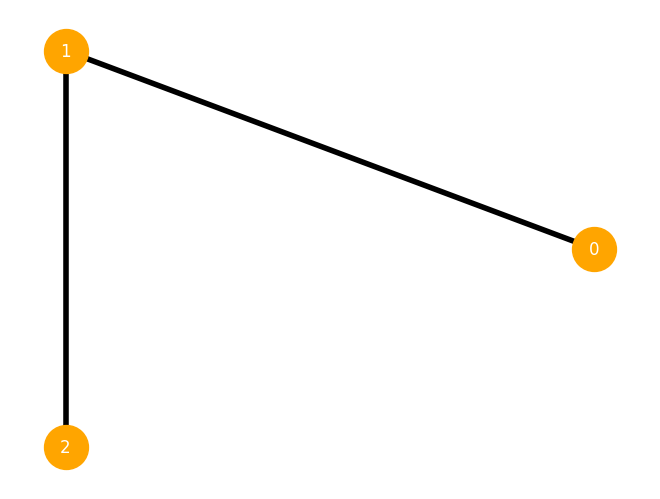

In [46]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 3
# num_iter = 5

N = 3
E = [(0,1), (1,2)]
num_iter = 5

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x1695760e0>>
Job Status: job has successfully run


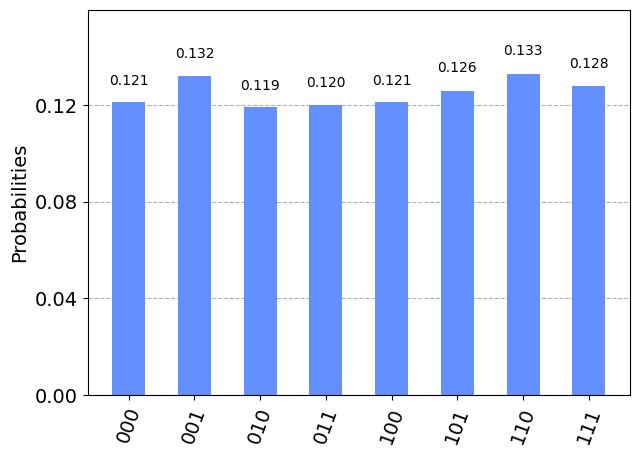

In [47]:
plot_result_noise_ibm(x1)

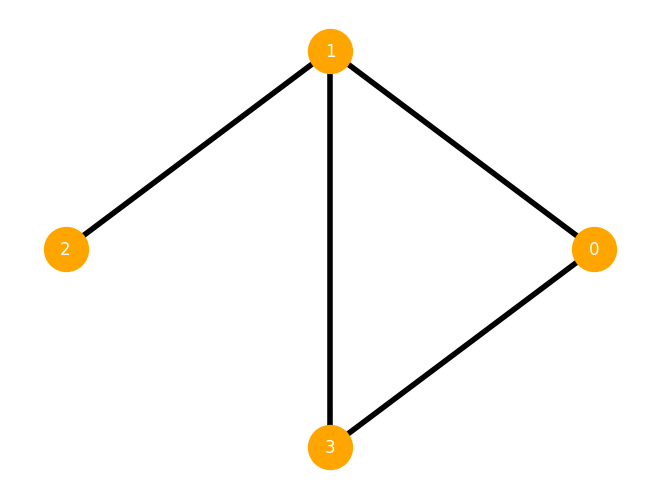

In [48]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 4
# num_iter = 5

N = 4
E = [(0,1), (1,2), (0,3), (1,3)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x167450d30>>
Job Status: job has successfully run


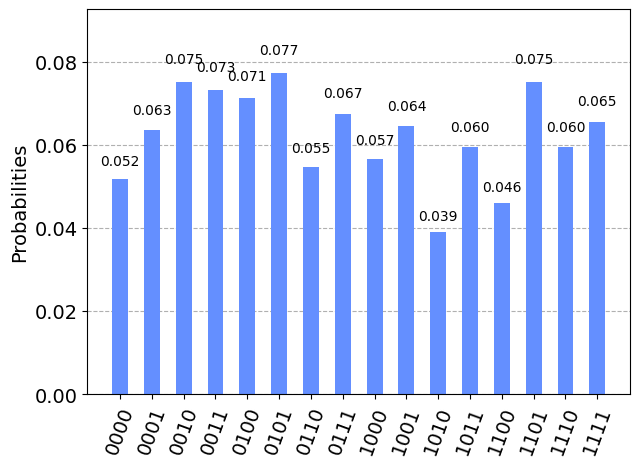

In [49]:
plot_result_noise_ibm(x2)

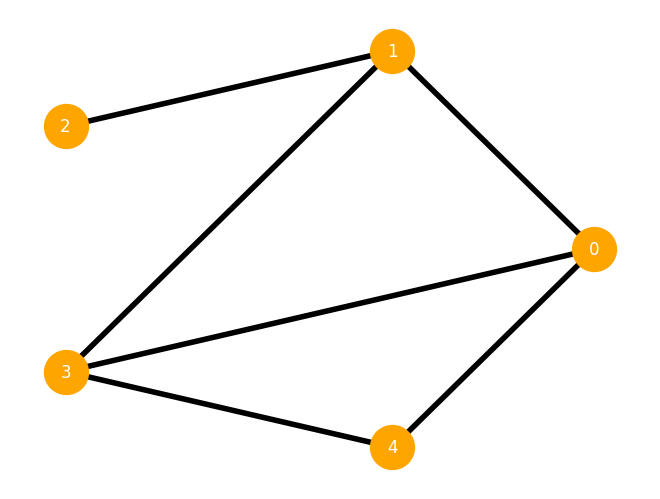

In [50]:
""" Running the cost function on non-noisy simulator and final circuit on IBM quantum computer"""

# nodes = 5
# num_iter = 5

N = 5
E = [(0,1), (1,2), (0,3), (1,3), (3,4), (0,4)]
num_iter = 5

# Defining parameters

n = N
conn_lis = connection_list(E, N)
shots_ = 1024

graph_draw(E)

<bound method IBMQJob.job_id of <qiskit.providers.ibmq.job.ibmqjob.IBMQJob object at 0x16972edd0>>
Job Status: job has successfully run


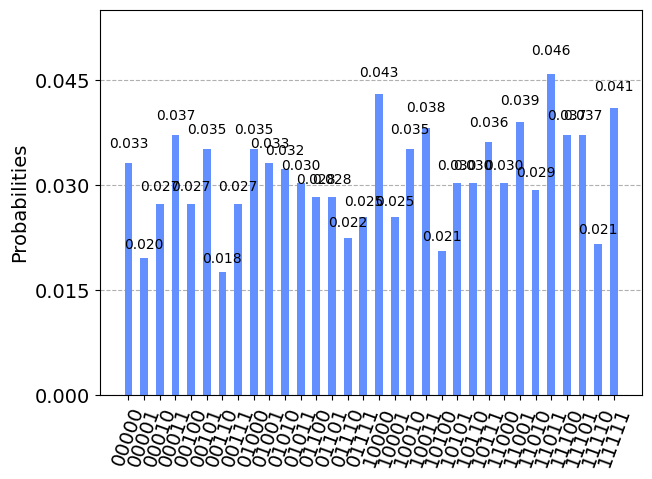

In [51]:
plot_result_noise_ibm(x3)